## Tail Latency

Рассмотрим задержку, которую испытывают запросы к некоторому сервису. В рамках этой лабы мы будем моделировать задержку с помощью логнормального распределения.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

In [2]:
latency_distribution = ss.lognorm(s=2, scale=np.exp(3))

mean = 148.1569
95% percentile = 535.7011
99% percentile = 2094.1641


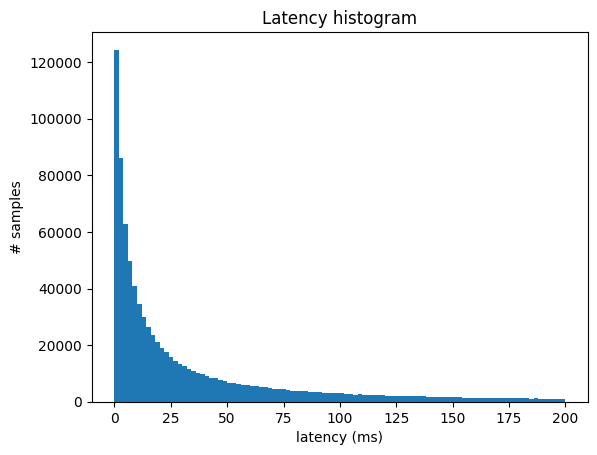

In [3]:
np.random.seed(111)
sample = latency_distribution.rvs(size=1000000)
plt.hist(sample, bins=100, range=(0, 200))
plt.xlabel('latency (ms)')
plt.ylabel('# samples')
plt.title('Latency histogram')
print(f'mean = {sample.mean():.4f}')
print(f'95% percentile = {np.quantile(sample, 0.95):.4f}')
print(f'99% percentile = {np.quantile(sample, 0.99):.4f}')

Видно, что средняя задержка нашего сервиса составляет около 150 миллисекунд, но 0.95 и 0.99 квантили заметно выше. Это означает, что некоторые (довольно редкие) запросы могут занимать гораздо больше времени, чем можно ожидать, глядя на среднее. Задержку, наблюдаемую на высоких квантилях распределения, называют **хвостовой задержкой (tail latency)**.

Учитывать хвостовую задержку следует по двум причинам. Во-первых, даже редкие всплески задержки весьма заметны для пользователя. Во-вторых, при взаимодействии с пользователем могут генерироваться не отдельные простые запросы, а какие-то сложные запросы, состоящие из отдельных простых. Именно такие запросы мы будем рассматривать далее.

## Serial latency

Начнем с простой цепочки вызовов: сервис A вызывает сервис B и ждет ответа, тот вызывает сервис C и т. д. Посмотрим на то, как меняется распределение задержек всей цепочки запросов при увеличении длины, и как меняется вероятность ответить за 1 секунду.

Generating request chains of length 3.
mean = 441.9032
95% percentile = 1570.3107
99% percentile = 4773.7790
Generating request chains of length 5.
mean = 738.0432
95% percentile = 2484.8959
99% percentile = 6807.5122
Generating request chains of length 11.
mean = 1637.3975
95% percentile = 4858.8708
99% percentile = 11857.8237


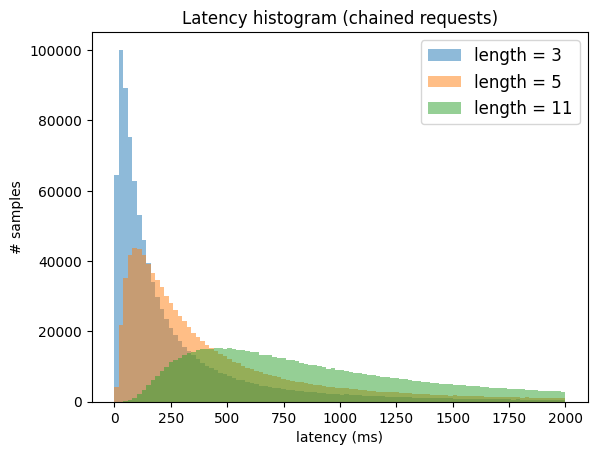

In [4]:
np.random.seed(112)
chains = [3, 5, 11]
plt.title(f'Latency histogram (chained requests)')
plt.xlabel('latency (ms)')
plt.ylabel('# samples')
for chain in chains:
    print(f'Generating request chains of length {chain}.')
    sample = latency_distribution.rvs(size=(1000000, chain)).sum(axis=1)
    plt.hist(sample, bins=100, range=(0, 2000), label=f'length = {chain}', alpha=0.5)
    print(f'mean = {sample.mean():.4f}')
    print(f'95% percentile = {np.quantile(sample, 0.95):.4f}')
    print(f'99% percentile = {np.quantile(sample, 0.99):.4f}')

plt.legend(loc=0, fontsize=12)

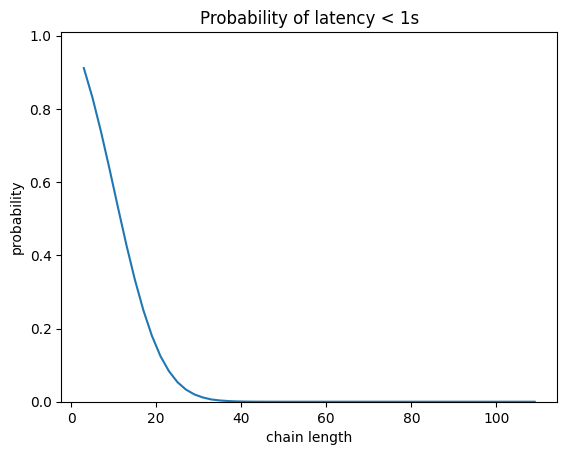

In [5]:
np.random.seed(112)
probs = []
sizes = np.arange(3, 111, 2)
for size in sizes:
    sample = latency_distribution.rvs(size=(1000000, size)).sum(axis=1)
    probs.append((sample < 1000.0).sum() / sample.shape[0])
plt.title('Probability of latency < 1s')
plt.ylabel('probability')
plt.xlabel('chain length')
plt.ylim(0, 1.01)
plt.plot(sizes, probs)

## Parallel latency

Теперь рассмотрим другой пример: сложный запрос, состоящий из $n$ параллельных подзапросов.

Generating parallel requests made of 3 simple requests.
mean = 384.0345
95% percentile = 1396.1884
99% percentile = 4539.3582
Generating parallel requests made of 5 simple requests.
mean = 580.4218
95% percentile = 2058.6549
99% percentile = 6323.8857
Generating parallel requests made of 11 simple requests.
mean = 1073.8273
95% percentile = 3650.5278
99% percentile = 10215.1142


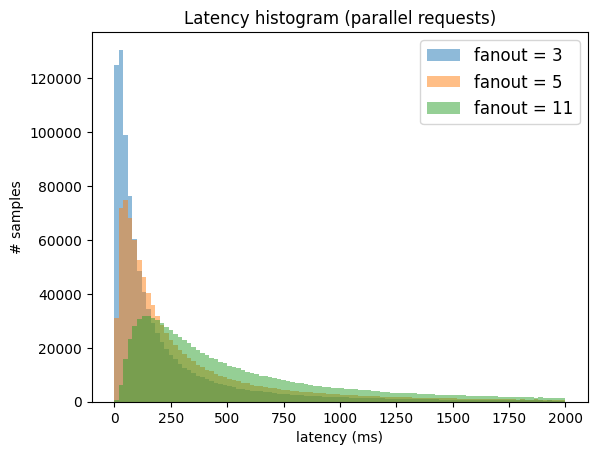

In [6]:
np.random.seed(113)
fanout = [3, 5, 11]
plt.title(f'Latency histogram (parallel requests)')
plt.xlabel('latency (ms)')
plt.ylabel('# samples')
for size in fanout:
    print(f'Generating parallel requests made of {size} simple requests.')
    sample = latency_distribution.rvs(size=(1000000, size)).max(axis=1)
    plt.hist(sample, bins=100, range=(0, 2000), label=f'fanout = {size}', alpha=0.5)
    print(f'mean = {sample.mean():.4f}')
    print(f'95% percentile = {np.quantile(sample, 0.95):.4f}')
    print(f'99% percentile = {np.quantile(sample, 0.99):.4f}')
    
plt.legend(loc=0, fontsize=12)

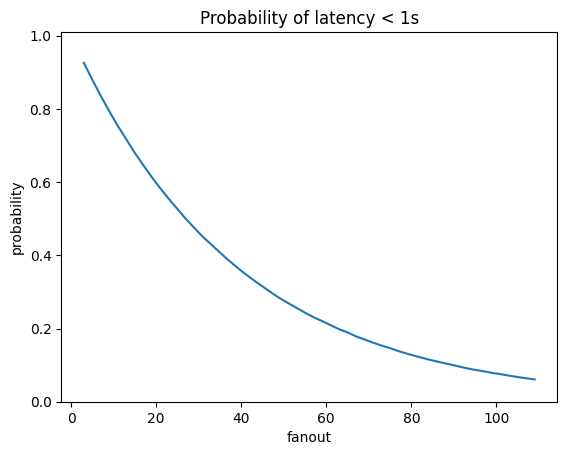

In [7]:
np.random.seed(113)
probs = []
sizes = np.arange(3, 111, 2)
for size in sizes:
    sample = latency_distribution.rvs(size=(1000000, size)).max(axis=1)
    probs.append((sample < 1000.0).sum() / sample.shape[0])
plt.title('Probability of latency < 1s')
plt.ylabel('probability')
plt.xlabel('fanout')
plt.ylim(0, 1.01)
plt.plot(sizes, probs)

## Quorum latency

На других семинарах мы рассматривали запросы чтения/записи, которые состояли из $n$ параллельных подзапросов к репликам, но вместо ожидания всех ответов нам было достаточно собрать кворум размера $n/2 + 1$. Рассмотрим задержку в таком случае.

Generating quorums made of 2/3 simple requests.
mean = 49.4682
95% percentile = 182.2152
99% percentile = 455.8699
Generating quorums made of 3/5 simple requests.
mean = 35.6712
95% percentile = 116.3755
99% percentile = 244.0729
Generating quorums made of 6/11 simple requests.
mean = 26.4413
95% percentile = 67.9792
99% percentile = 113.1994


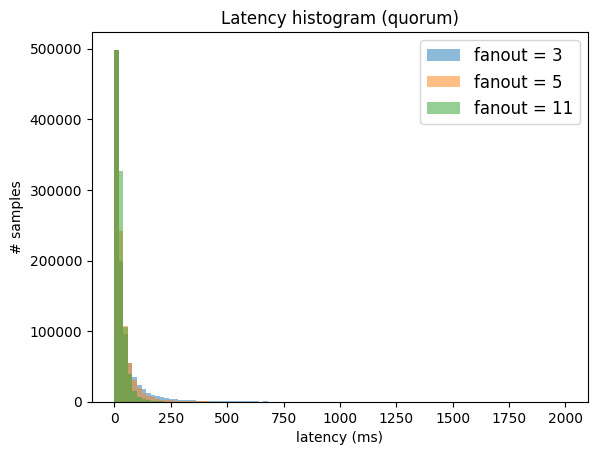

In [8]:
np.random.seed(113)
fanout = [3, 5, 11]
plt.title(f'Latency histogram (quorum)')
plt.xlabel('latency (ms)')
plt.ylabel('# samples')
for size in fanout:
    print(f'Generating quorums made of {size // 2 + 1}/{size} simple requests.')
    sample = np.median(latency_distribution.rvs(size=(1000000, size)), axis=1)
    plt.hist(sample, bins=100, range=(0, 2000), label=f'fanout = {size}', alpha=0.5)
    print(f'mean = {sample.mean():.4f}')
    print(f'95% percentile = {np.quantile(sample, 0.95):.4f}')
    print(f'99% percentile = {np.quantile(sample, 0.99):.4f}')
    
plt.legend(loc=0, fontsize=12)

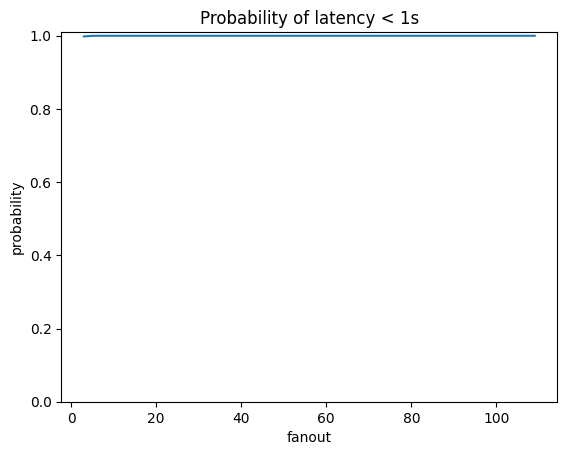

In [9]:
np.random.seed(113)
probs = []
sizes = np.arange(3, 111, 2)
for size in sizes:
    sample = np.median(latency_distribution.rvs(size=(1000000, size)), axis=1)
    probs.append((sample < 1000.0).sum() / sample.shape[0])
plt.title('Probability of latency < 1s')
plt.ylabel('probability')
plt.xlabel('fanout')
plt.ylim(0, 1.01)
plt.plot(sizes, probs)

## Hedged requests

Напоследок рассмотрим один способ бороться с большой хвостовой задержкой -- **hedged requests**. 
Суть в том, что при слишком долгом ожидании ответа (например, если время ожидания превышает 0.95 квантиль) можно отправить ещё один аналогичный запрос на другую реплику.
Если причина задержки не затрагивает сразу несколько реплик (то есть это не какие-то глобальные проблемы с сетью в датацентре), то подобный способ может уменьшить более высокие квантили.

Generating parallel requests made of 3 simple requests.
mean retry count = 0.13
mean = 195.8579
95% percentile = 578.5744
99% percentile = 793.2513
Generating parallel requests made of 5 simple requests.
mean retry count = 0.22
mean = 273.9621
95% percentile = 623.2783
99% percentile = 917.6242
Generating parallel requests made of 11 simple requests.
mean retry count = 0.49
mean = 417.0429
95% percentile = 731.9073
99% percentile = 1167.1777


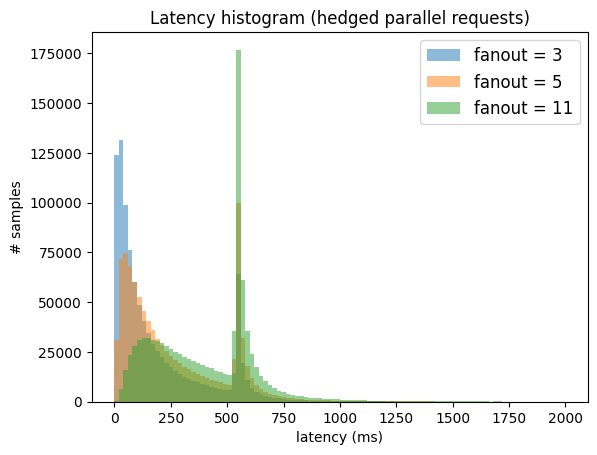

In [10]:
np.random.seed(114)
fanout = [3, 5, 11]
plt.title(f'Latency histogram (hedged parallel requests)')
plt.xlabel('latency (ms)')
plt.ylabel('# samples')
cutoff = latency_distribution.ppf(0.95)
for size in fanout:
    print(f'Generating parallel requests made of {size} simple requests.')
    sample = latency_distribution.rvs(size=(1000000, size))
    sample2 = latency_distribution.rvs(size=(1000000, size))
    count = (sample > sample2 + cutoff).sum(axis=1)
    print(f'mean retry count = {count.mean():.2f}')
    sample = np.minimum(sample, sample2 + cutoff).max(axis=1)
    plt.hist(sample, bins=100, range=(0, 2000), label=f'fanout = {size}', alpha=0.5)
    print(f'mean = {sample.mean():.4f}')
    print(f'95% percentile = {np.quantile(sample, 0.95):.4f}')
    print(f'99% percentile = {np.quantile(sample, 0.99):.4f}')
    
plt.legend(loc=0, fontsize=12)

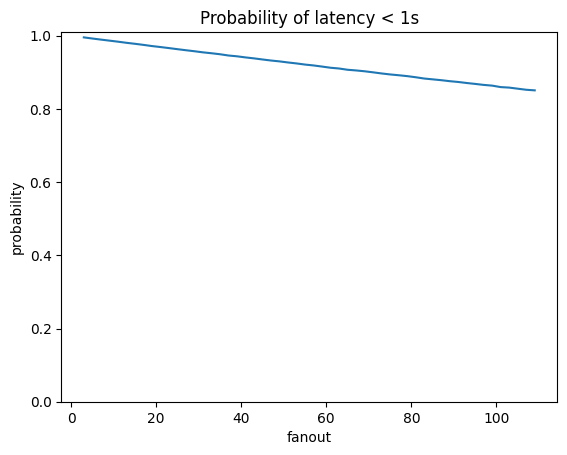

In [11]:
np.random.seed(114)
probs = []
sizes = np.arange(3, 111, 2)
for size in sizes:
    sample = latency_distribution.rvs(size=(1000000, size))
    sample2 = latency_distribution.rvs(size=(1000000, size))
    sample = np.minimum(sample, sample2 + cutoff).max(axis=1)
    probs.append((sample < 1000.0).sum() / sample.shape[0])
plt.title('Probability of latency < 1s')
plt.ylabel('probability')
plt.xlabel('fanout')
plt.ylim(0, 1.01)
plt.plot(sizes, probs)